# Neural differential equations

As illustrated in the [previous notebook](./01-machine-learning.ipynb), neural networks is a non-linear combination of linear functions, e.g.,

$$f(x) = \mathrm{tanh}\left(a_1\left(a_2\,\mathrm{tanh}(x)+b_2  \right)+b_1\right)$$

System with time dynamics are often described by differential equations (e.g. reaction kinetics),

$$\cfrac{\mathrm{d}x(t)}{\mathrm{d}t} = v(t)$$

This equation descrives the evolution of the distance ($x$) as a function of time.

Often, the phenomena we want to model involves compex dynamics in which case a machine learning approach can be adopted. Since we already know artificial neural networks and differential equations let's combine the two,

$$\cfrac{\mathrm{d}x(t)}{\mathrm{d}t} = \mathrm{tanh}\left(a_1\left(a_2\,\mathrm{tanh}(x)+b_2  \right)+b_1\right)\, .$$

Et voila! We have a neural differential equations. Let's put this methodology to test.

## Learning biochemical reaction dynamics

We have some data on the production of sucrose esters,

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Sucrose_monostearate.svg/500px-Sucrose_monostearate.svg.png)

Which can be produced by using reacting a lipase enzyme in an organic solvent, forcing the reverse reaction, 

sucrose (S) + fatty acid (A) ⇄ sucrose fatty acid ester (Es) + water. 

The reaction kinetics are complex due to due to substrate and product inhibition.

In [97]:
include("./src/helper-functions.jl");

In [98]:
using OrdinaryDiffEq, Plots
import Random
Random.seed!(1234);

In [99]:
C₀ = Float32[45.0; 60.0; 0.0]
tₑ = 360.0f0;

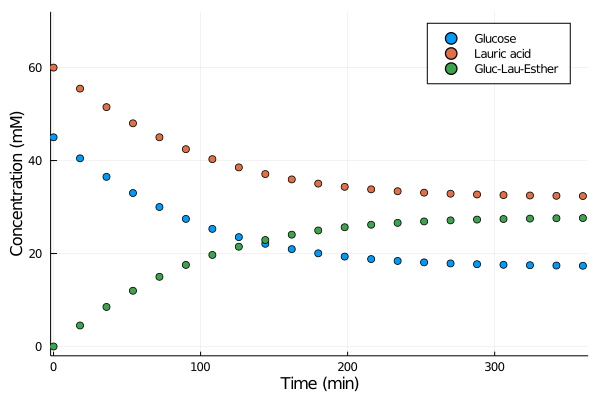

In [100]:
data = generate_true_solution(C₀, tₑ);
plot_reaction(data)

## Training on a single experiment

In [101]:
C, time = data;

In [102]:
using DiffEqFlux, Flux

In [103]:
ann = Chain(Dense(3, 20, σ), Dense(20, 8, σ), Dense(8,1), x->x.*[1.0; 1.0; -1.0])


p, re = Flux.destructure(ann) # use this p as the initial condition!
dCdt(u,p,t) = re(p)(u) # need to restrcture for backprop!

prob = ODEProblem(dCdt, C₀, (0, tₑ))

function predict_neuralODE(C₀)
    Array(solve(prob,Tsit5(),u0=C₀,p=p,saveat=time))
end

predict_neuralODE (generic function with 1 method)

In [104]:
L₁() = sum((C.-predict_neuralODE(C₀)).^2);

In [105]:
cb = function (;doplot = true)
  # plot current prediction against data
    pred = predict_neuralODE(C₀)
    pl = prediction_vs_data(data, pred)

    if doplot
        IJulia.clear_output(true)
        display(plot(pl))
    end
    return false
end

#103 (generic function with 1 method)

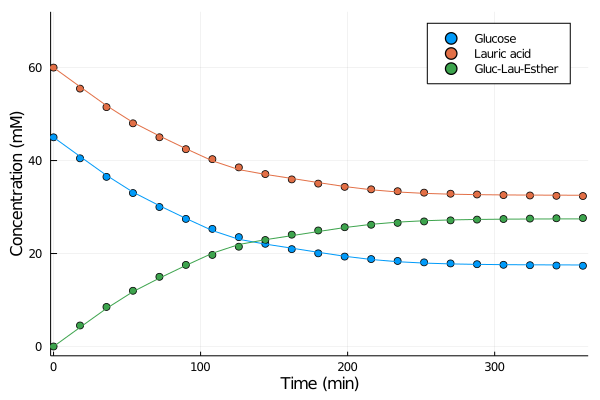

In [106]:
epochs = Iterators.repeated((), 300)
Flux.train!(L₁, Flux.params(p), epochs, ADAM(0.04), cb = cb)

### Testing

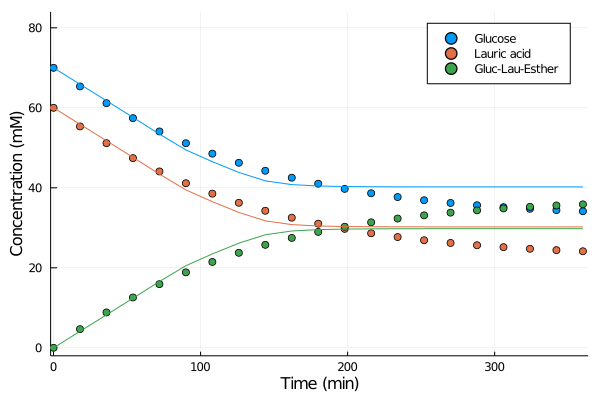

In [107]:
C₀ = Float32[70.0; 60.0; 0.0]
data = generate_true_solution(C₀, tₑ);
pred = predict_neuralODE(C₀)
pl = prediction_vs_data(data, pred)

## Adding more experiments

In [108]:
initialConditions = 
[
    Float32[30.0; 60.0; 0.0],
    Float32[45.0; 60.0; 0.0],
    Float32[60.0; 60.0; 0.0],
    Float32[30.0; 60.0; 15.0],
    Float32[45.0; 60.0; 15.0],
    Float32[60.0; 60.0; 15.0],
    Float32[30.0; 60.0; 30.0],
    Float32[45.0; 60.0; 30.0],
    Float32[60.0; 60.0; 30.0],
    #Float32[15.0; 60.0; 0.0],
    #Float32[15.0; 60.0; 15.0],
    #Float32[15.0; 60.0; 30.0]
];

In [109]:
datasets = [generate_true_solution(C₀, tₑ) for C₀ in initialConditions];

In [110]:
function trainingLoss()
    loss = 0.0
        
    for (index, C₀) in enumerate(initialConditions)
        C, time = datasets[index]  
        pred = predict_neuralODE(C₀)
        loss += sum((C.-pred).^2);
    end
    return loss
end;

In [111]:
cb4 = function (;doplot = true)
  # plot current prediction against data
    
    l = @layout [a b; c d]
    pls = []
    for C₀ in initialConditions[1:4]
        data = generate_true_solution(C₀, tₑ);
        C, time = data  
        pred = predict_neuralODE(C₀)
        push!(pls, prediction_vs_data(data, pred))
    end
    
    if doplot
        IJulia.clear_output(true)
        pl = plot(pls[1], pls[2], pls[3], pls[4], layout = l, size=(900, 700))
        display(pl)
    end
    return false
end;

In [112]:
epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.075)) 

epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.05)) 

epochs = Iterators.repeated((), 200)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.01)) 

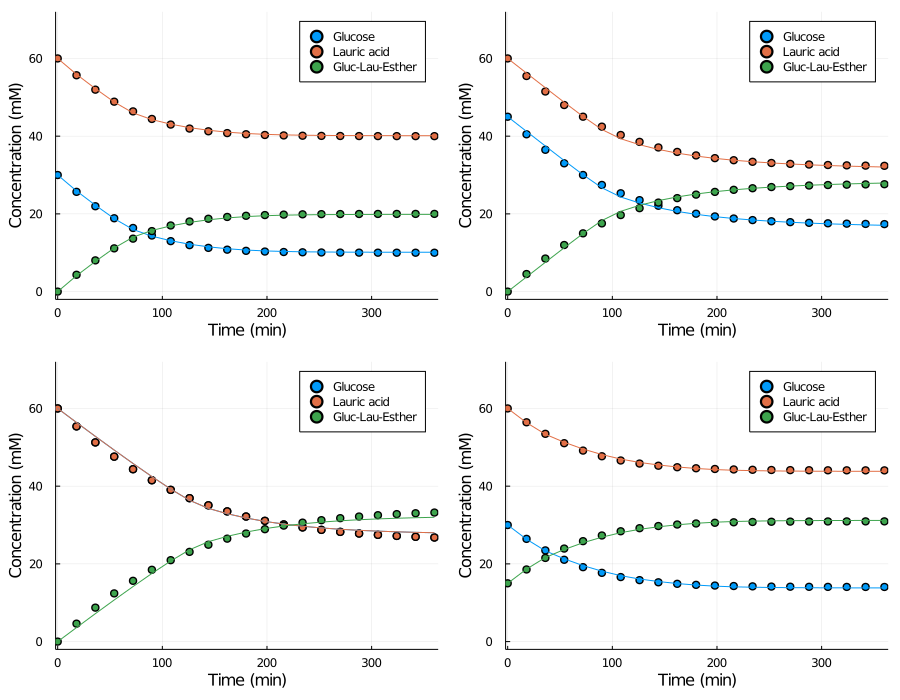

false

In [113]:
cb4()

## How well did we learn the true kinetics? 

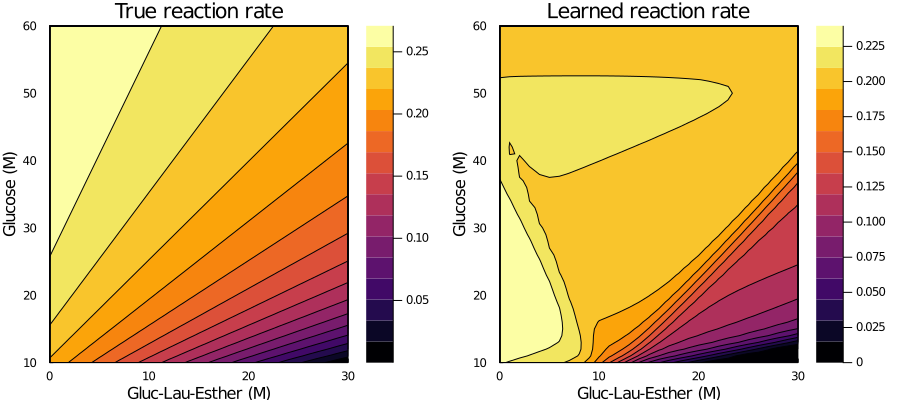

In [114]:
G = 10:1.0:60
L = 60.0
Es = 0.0:1.0:30.0

X = Iterators.product(G, L, Es)
l = @layout [a b]
c₁ = contourf(Es, G, rate.(X), 
        xlabel = "Gluc-Lau-Esther (M)", 
        ylabel="Glucose (M)", 
        title="True reaction rate")

R = [dCdt([C[1]; C[2]; C[3]], p, 0.0)[3] for C in X]
c₂ = contourf(Es, G, min.(max.(R, 0.0), maximum(R)), 
        xlabel = "Gluc-Lau-Esther (M)", 
        ylabel="Glucose (M)", 
        title="Learned reaction rate")

G = [C[1] for C in initialConditions]
Es = [C[3] for C in initialConditions]

#scatter!(Es, G, grid=false, label="")

plot(c₁, c₂, layout=l, size=(900, 400))

## Saving model parameters

In [115]:
open("model/trainedModel.csv", "w") do file
    print(file, p)
end